# Добавление в модель признаков, полученных на основе другой модели

<center><img src ="https://ml.gan4x4.ru/msu/additions/L04/generating_features_using_model.png" width="700"></center>

<center><em><b>Генерация бинарного признакового пространства с помощью RandomForest</b></em></center>

Рассмотрим пример, в котором для кодирования значений признаков используется результат работы ансамбля деревьев, а затем на закодированных данных обучается линейная модель.

В этом примере сначала на отдельной выборке обучается ансамбль деревьев (случайный лес и градиентный бустинг), и каждому листу каждого дерева в ансамбле присваивается уникальный индекс.

Для кодирования с помощью обученного ансамбля каждый объект проходит по всем деревьям. В каждом дереве он оказывается в одном из листьев и получает в качестве нового признака индекс этого листа. Таким образом создается новое пространство признаков. После этого новые признаки (индексы листьев) кодируются по принципу one-hot ecnoding.

Для начала создадим датасет и разобьем его на три отдельные части:
* часть для обучения ансамбля деревьев;
* часть для обучения линейной модели;
* часть для тестирования линейной модели.

Важно обучать ансамбль деревьев на ином подмножестве обучающих данных, чем модель линейной регрессии, чтобы избежать переобучения, в частности, если общее количество листьев окажется равно количеству обучающих образцов или близко к нему.

In [ ]:
### https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

np.random.seed(42)

# define dummy dataset
x, y = make_classification(n_samples=80000, random_state=42)

# split dataset into subsets for training ensemble and linear model and final testing of the linear model
x_full_train, x_test, y_full_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=42
)

# split training subset into parts for ensemble training and for linear model training
x_train_ensemble, x_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    x_full_train, y_full_train, test_size=0.5, random_state=42
)

Теперь можем обучить ансабли на специально отложенных для этого данных, а затем применить их для кодирования обучающей и тестовой выборок для линейной модели. На закодированных данных мы обучаем модель логистической регрессии, а затем строим ROC-кривые, чтобы сравнить качество разных подходов.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder

n_estimator = 10

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=42)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)

rf.fit(x_train_ensemble, y_train_ensemble)
rf_enc.fit(rf.apply(x_train_ensemble))  # apply method return leaf indices
rf_lm.fit(rf_enc.transform(rf.apply(x_train_linear)), y_train_linear)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(x_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)


# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator, random_state=42)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)

grd.fit(x_train_ensemble, y_train_ensemble)
grd_enc.fit(grd.apply(x_train_ensemble)[:, :, 0])  # apply method return leaf indices
grd_lm.fit(grd_enc.transform(grd.apply(x_train_linear)[:, :, 0]), y_train_linear)

y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(x_test)[:, :, 0]))[
    :, 1
]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

Также для сравнения протестируем обученные ансамбли на той же тестовой выборке.

In [ ]:
# The random forest model by itself
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

Построим ROC-кривые для четырех моделей:
* случайный лес, обученный на исходных данных;
* логистическая регрессия, обученная на данных, закодированных с помощью случайного леса;
* градиентный бустинг, обученный на исходных данных;
* логистическая регрессия, обученная на данных, закодированных с помощью градиентного бустинга.

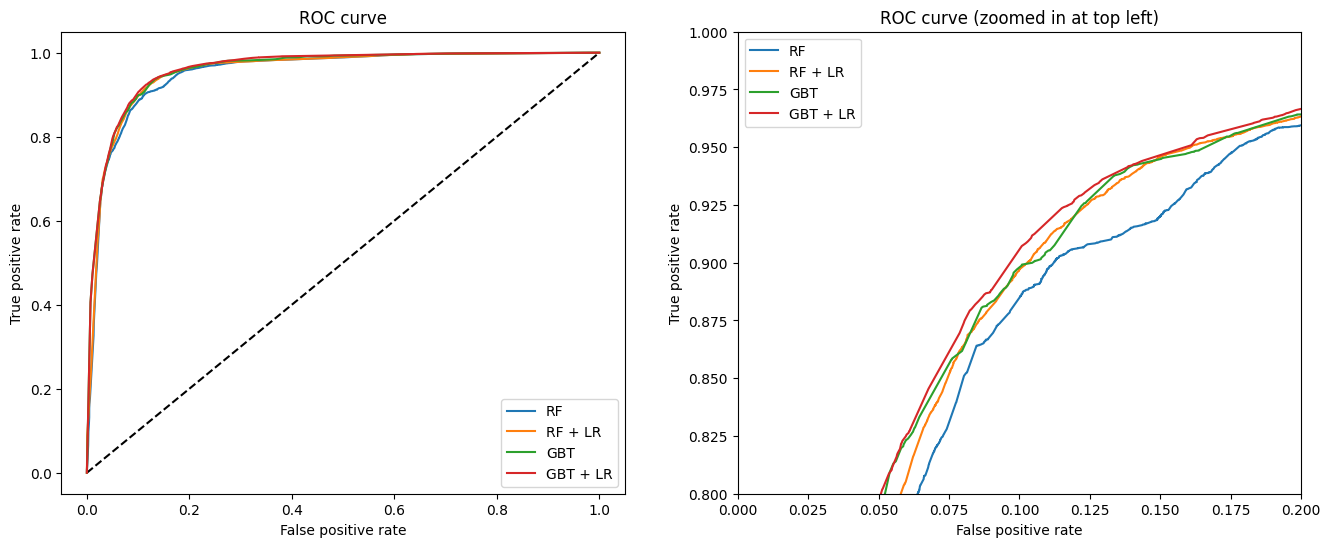

In [ ]:
import matplotlib.pyplot as plt

# Plot figure 1 and figure 2 with subplots
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1.plot([0, 1], [0, 1], "k--")
ax1.plot(fpr_rf, tpr_rf, label="RF")
ax1.plot(fpr_rf_lm, tpr_rf_lm, label="RF + LR")
ax1.plot(fpr_grd, tpr_grd, label="GBT")
ax1.plot(fpr_grd_lm, tpr_grd_lm, label="GBT + LR")
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate")
ax1.set_title("ROC curve")
ax1.legend(loc="best")

ax2.set_xlim(0, 0.2)
ax2.set_ylim(0.8, 1)
ax2.plot([0, 1], [0, 1], "k--")
ax2.plot(fpr_rf, tpr_rf, label="RF")
ax2.plot(fpr_rf_lm, tpr_rf_lm, label="RF + LR")
ax2.plot(fpr_grd, tpr_grd, label="GBT")
ax2.plot(fpr_grd_lm, tpr_grd_lm, label="GBT + LR")
ax2.set_xlabel("False positive rate")
ax2.set_ylabel("True positive rate")
ax2.set_title("ROC curve (zoomed in at top left)")
ax2.legend(loc="best")

plt.show()

На этом модельном примере видим, что применение комбинации моделей (кодирование данных с помощью ансамбля деревьев и классификация с помощью линейной модели) позволяет достичь более высокого качества классификации.